In [16]:
import numpy as np

percents = [8.23, 8.07, 13.98, 3.65, 5.10, 2.67, 15.08, 6.94, 3.28, 18.72, 10.16, 3.55, 0.58]
classes = [
'building',
'pervious',
'impervious',
'bare soil',
'water',
'coniferous',
'deciduous',
'brushwood',
'vineyard',
'herbaceous',
'agricultural',
'plowed land',
'other']

print([np.round(np.nan_to_num(max(percents)/c), 1) for c in percents])
print([np.round(np.nan_to_num((sum(percents) - c)/c), 1) for c in percents])

[2.3, 2.3, 1.3, 5.1, 3.7, 7.0, 1.2, 2.7, 5.7, 1.0, 1.8, 5.3, 32.3]
[11.2, 11.4, 6.2, 26.4, 18.6, 36.5, 5.6, 13.4, 29.5, 4.3, 8.8, 27.2, 171.4]


In [17]:
np.arange(12)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

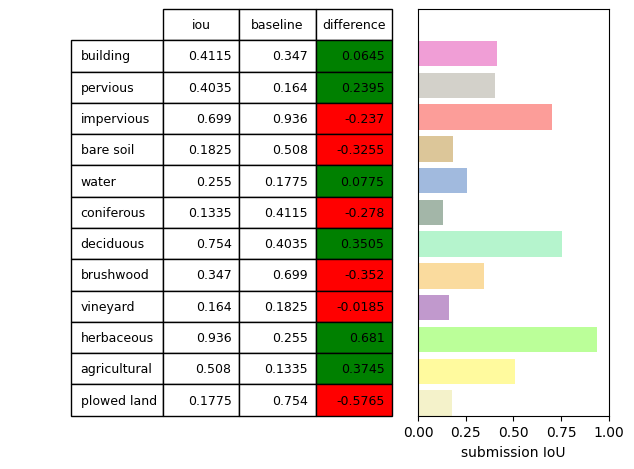

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
lut_colors = [
'#db0e9a',
'#938e7b',
'#f80c00',
'#a97101',
'#1553ae',
'#194a26',
'#46e483',
'#f3a60d',
'#660082',
'#55ff00',
'#fff30d',
'#e4df7c',
'#000000'
]

# Example data
y_pos = np.arange(len(classes)-1) #- .2
#y_pos_2 = np.arange(len(classes)-1) + .2
iou = [8.23, 8.07, 13.98, 3.65, 5.10, 2.67, 15.08, 6.94, 3.28, 18.72, 10.16, 3.55]
iou = [round(i/20, 4) for i in iou]
baseline = [6.94, 3.28, 18.72, 10.16, 3.55, 8.23, 8.07, 13.98, 3.65, 5.10, 2.67, 15.08]
baseline = [round(i/20, 4) for i in baseline]
diff = [round(i-b, 4) for i,b in zip(iou, baseline)]

bar_width = .8
fig, axs = plt.subplots(1,2, width_ratios=[2, 1])

axs[1].barh(y_pos[::-1], iou, bar_width,  align='center', alpha=0.4, color=lut_colors[:-1])
#axs[1].barh(y_pos_2[::-1], baseline, bar_width,  align='center', alpha=0.4, color=lut_colors[:-1])

axs[1].set_yticks([])
axs[1].set_xlabel('submission IoU')
axs[1].set_ylim(0 - .4, (len(classes)-1) + .4)
axs[1].set_xlim(0, 1)

cell_text = list(zip(iou, baseline, diff))
c = ['r' if d<0 else 'g' for d in diff]
cellColours = list(zip(['white']*12, ['white']*12, c))

column_labels = ['iou', 'baseline', 'difference']

axs[0].axis('off')

the_table = axs[0].table(
    cellText=cell_text,
    cellColours=cellColours,
    rowLabels=classes[:-1],
    colLabels=column_labels,
    bbox=[0.4, 0.0, 0.6, 1.0]
)

#the_table.auto_set_font_size(False)
#the_table.set_fontsize(12)
#fig.subplots_adjust(wspace=0, top=1, right=1, left=0, bottom=0)
fig.tight_layout()
fig.savefig('test.png')


/work/OT/ai4usr/fournip/vre_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[1075065, 1595299, 20637, 835205, 473794]


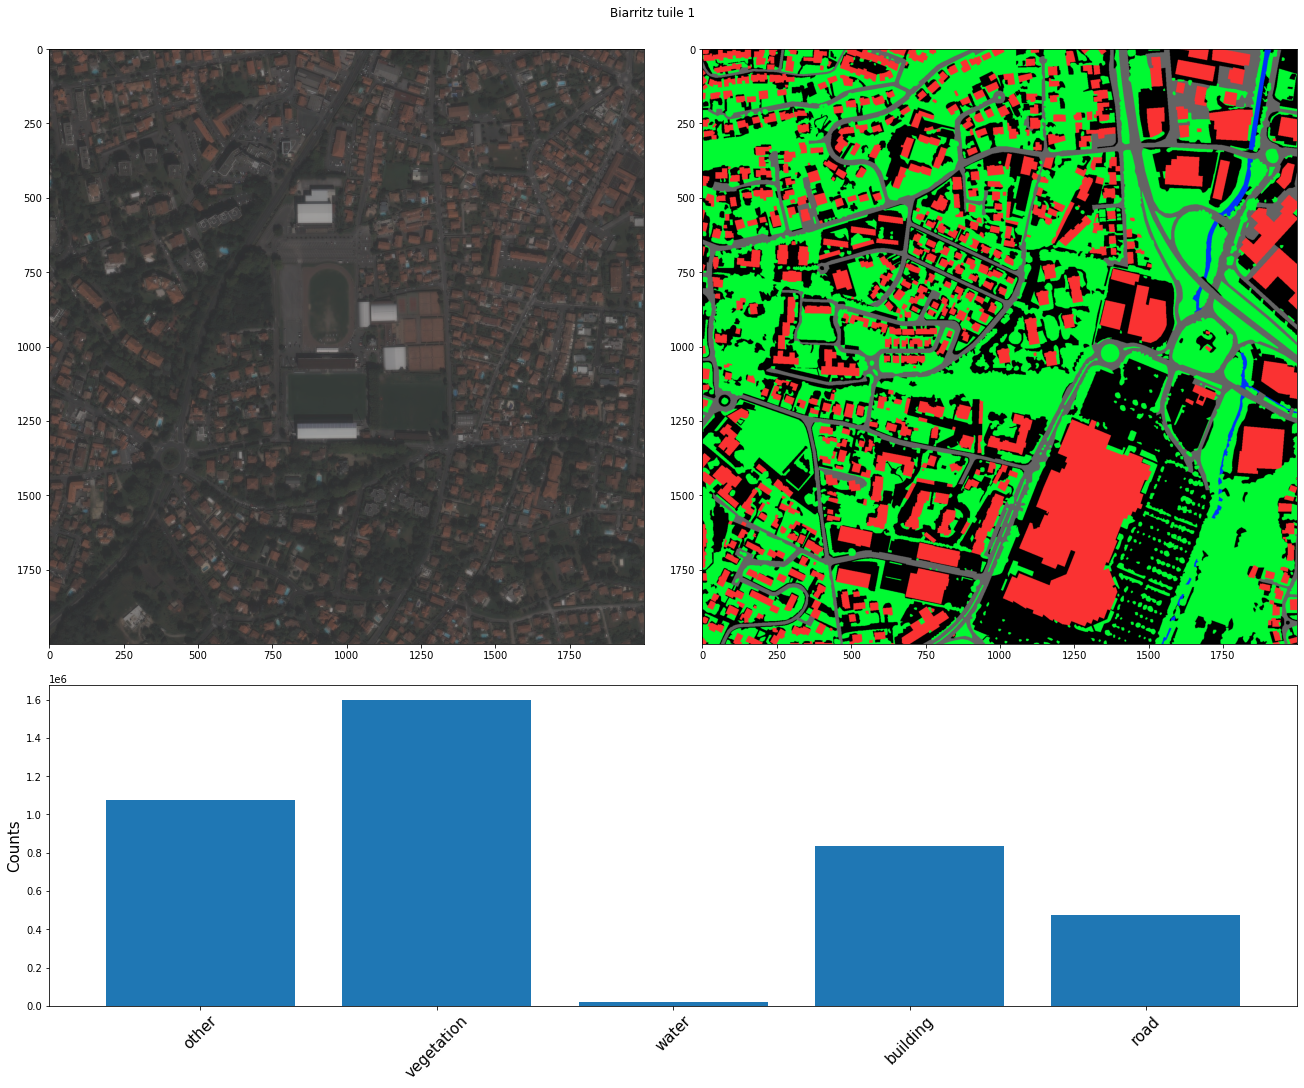

[900639, 1400728, 952, 949937, 747744]


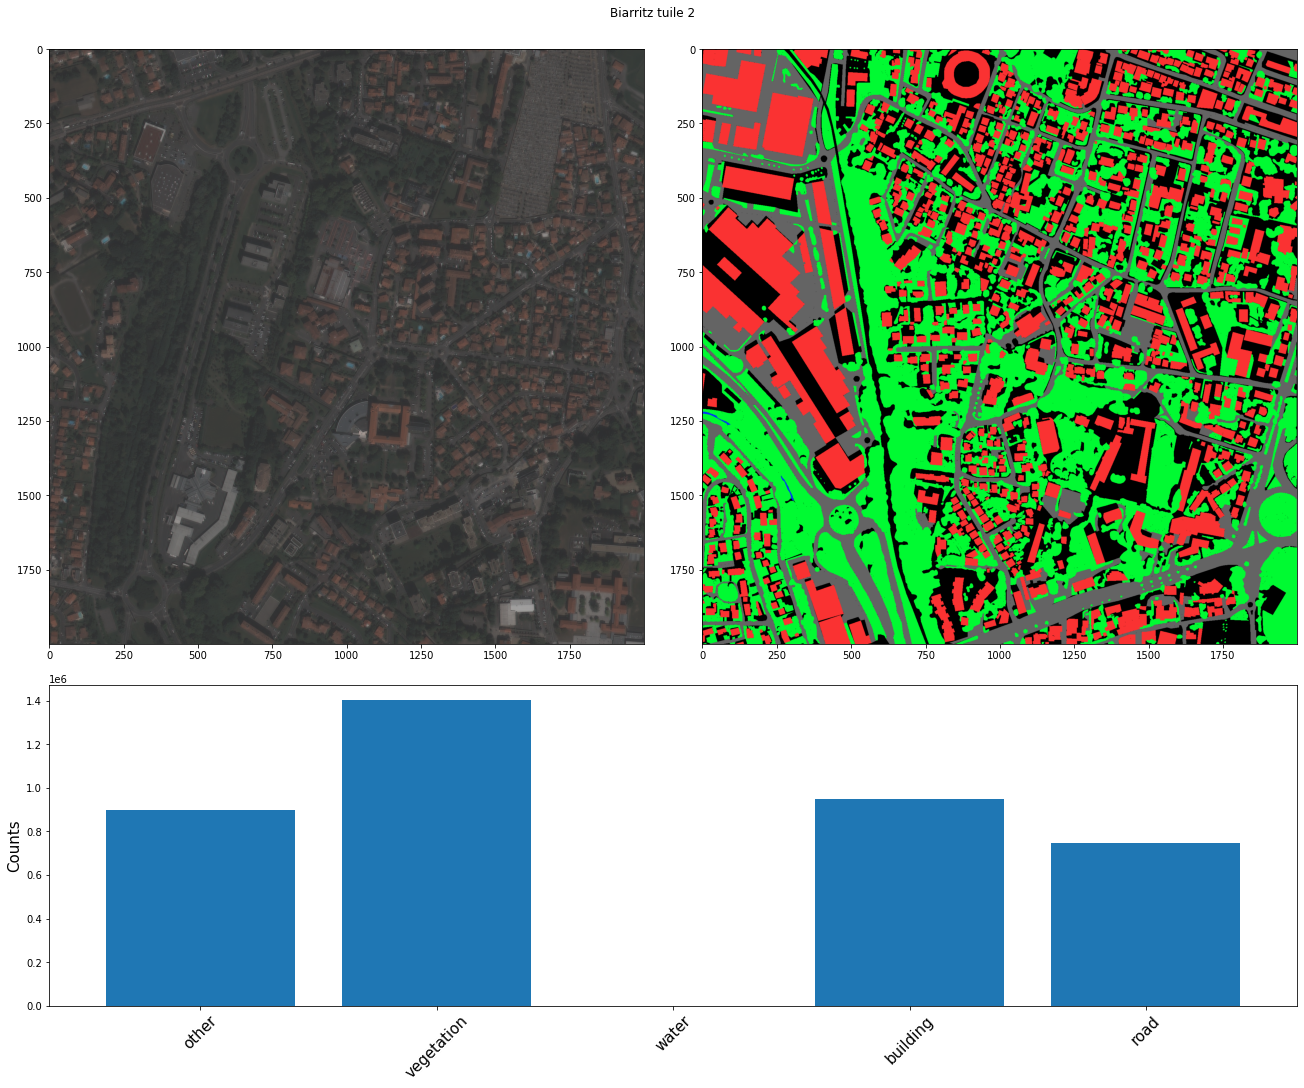

[1975704, 2996027, 21589, 1785142, 1221538]
[1.5, 1.0, 138.8, 1.7, 2.5]
[3.0, 1.7, 369.6, 3.5, 5.5]


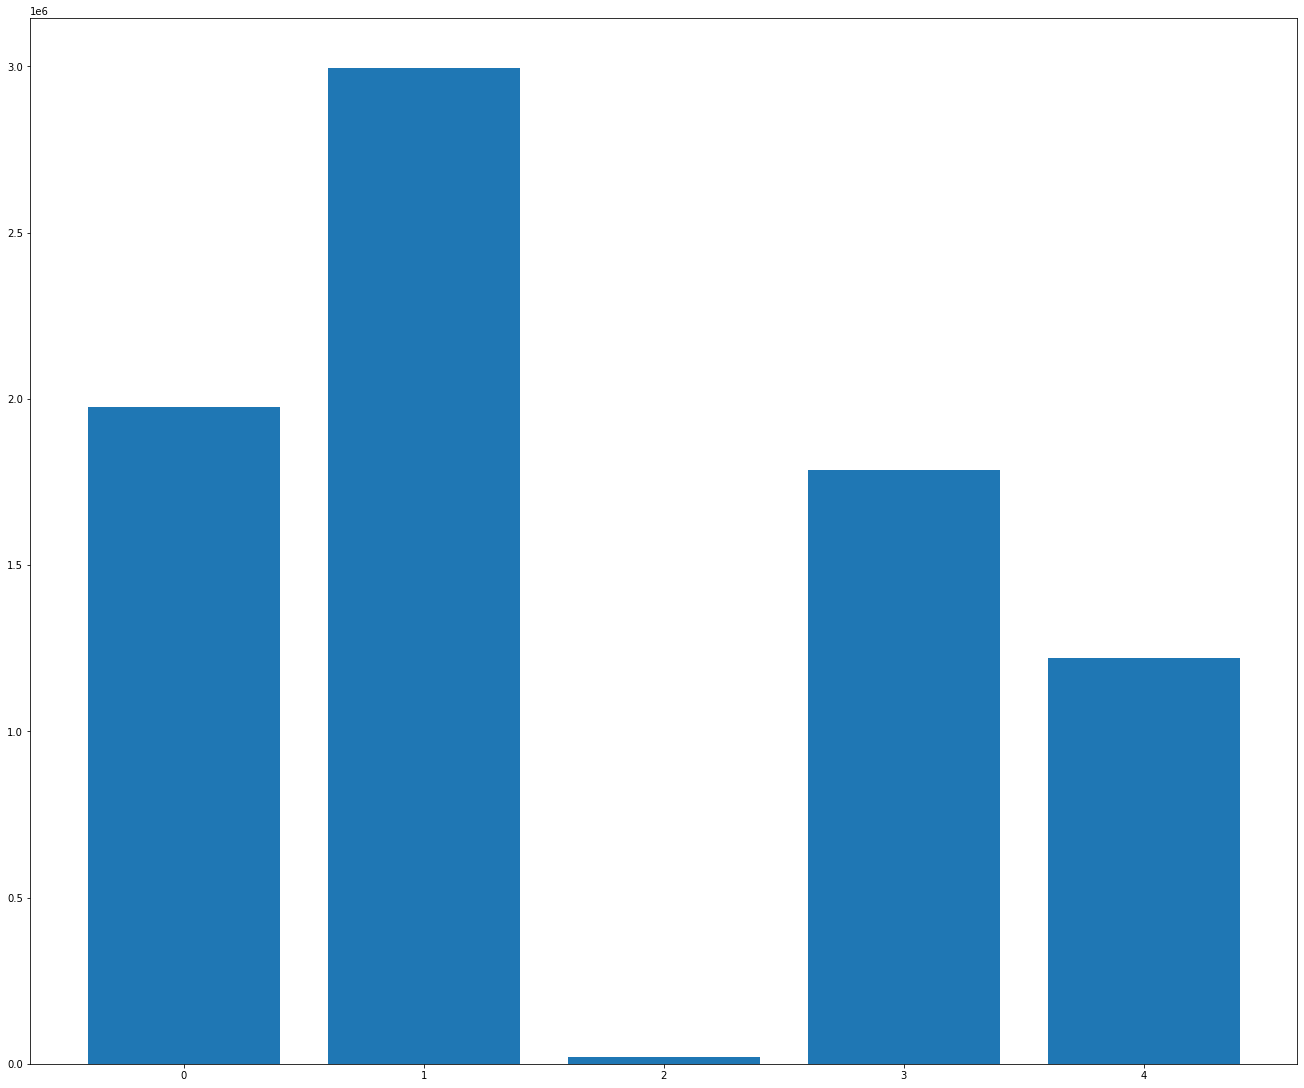

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import exposure
import rasterio
import numpy as np
from dl_toolbox.torch_datasets import *
from dl_toolbox.utils import *
import dl_toolbox.inference as dl_inf

city = 'Biarritz'
CLASS = DigitanieBiarritzDs
FULL_RASTER_PATH = f'/work/OT/ai4usr/fournip/digitanie/{city}/{city.lower()}_full_tiled.tif'
LABEL_PATHS = [f'/work/OT/ai4usr/fournip/digitanie/{city}/{city.lower()}_tuile_{i}.tif' for i in range(1, 3)]
IMAGE_PATHS = [f'/work/OT/ai4usr/fournip/digitanie/{city}/{city.lower()}_tuile_{i}_img_normalized.tif' for i in range(3, 11)]


TILE = (0, 0, 2000, 2000)
CROP_SIZE = 512
CROP_STEP = 400
LABELS='5class'
MERGE='5class'

window = dl_inf.get_window(TILE)
dataset = CLASS(
    labels=LABELS,
    label_merger=MERGE,
    image_path=None,
    label_path=None,
    full_raster_path=FULL_RASTER_PATH,
    fixed_crops=True,
    tile=window,
    crop_size=CROP_SIZE,
    crop_step=CROP_STEP,
    img_aug='no'
)

num_class = len(dataset.labels)
counts_tot = [0] * num_class
for i, (label_path, image_path) in enumerate(zip(LABEL_PATHS, IMAGE_PATHS)):

    image = dataset.read_image(
        image_path=image_path,
        window=window
    )
    image = image.transpose(1,2,0)
    image = exposure.adjust_gamma(image, 0.5)

    labels = dataset.read_label(
        label_path,
        window=window
    )
    labels_rgb = dataset.labels_to_rgb(labels)
    
    fig = plt.figure(figsize=(18, 15), constrained_layout=True)
    fig.suptitle(f'{city} tuile {i+1}')
    spec = fig.add_gridspec(nrows=3, ncols=2)
    
    ax00 = fig.add_subplot(spec[:-1, 0])
    ax00.imshow(image)

    ax01 = fig.add_subplot(spec[:-1, 1])
    ax01.imshow(labels_rgb)
    
    counts = [0] * num_class
    for j in range(len(dataset.labels)):
        counts[j] += len(np.nonzero(labels == j)[0])
    print(counts)
    ax1 = fig.add_subplot(spec[-1, :])
    ax1.bar(
        x=range(num_class),
        height=counts
    )
    class_names = dataset.labels.keys()
    tick_marks = np.arange(len(class_names))
    ax1.set_xticks(tick_marks)
    ax1.set_xticklabels(class_names, rotation=45, fontsize=15)
    ax1.set_ylabel("Counts", fontsize=15)
    plt.show()
    
    
    counts_tot = [x + y for x, y in zip(counts_tot, counts)]

fig = plt.figure(figsize=(18, 15), constrained_layout=True)
plt.bar(
    x=range(num_class),
    height=counts_tot
)

print(counts_tot)
print([np.round(np.nan_to_num(max(counts_tot)/c), 1) for c in counts_tot])
print([np.round(np.nan_to_num((sum(counts_tot) - c)/c), 1) for c in counts_tot])

In [14]:
counts = [0] * 11
for i in range(1, 11):
    src = rasterio.open(f'/work/OT/ai4usr/fournip/digitanie/Strasbourg/strasbourg_tuile_{i}.tif')
    img = src.read(out_dtype=np.uint8)
    for j in range(11):
        counts[j] += len(np.nonzero(img == j)[0])
print(counts)
print([np.round(max(counts)/c, 1) for c in counts])
print([np.round((sum(counts) - c)/c, 1) for c in counts])

[2554656, 1500603, 11029316, 1251002, 5283814, 8984781, 1566508, 3600450, 3647471, 566924, 14475]
[4.3, 7.3, 1.0, 8.8, 2.1, 1.2, 7.0, 3.1, 3.0, 19.5, 762.0]
[14.7, 25.7, 2.6, 31.0, 6.6, 3.5, 24.5, 10.1, 10.0, 69.6, 2762.4]


In [15]:
counts = [0] * 11
for i in range(1, 11):
    src = rasterio.open(f'/work/OT/ai4usr/fournip/digitanie/Biarritz/biarritz_tuile_{i}.tif')
    img = src.read(out_dtype=np.uint8)
    for j in range(11):
        counts[j] += len(np.nonzero(img == j)[0])
print(counts)
print([np.round(max(counts)/c, 1) for c in counts])
print([np.round((sum(counts) - c)/c, 1) for c in counts])

[2508159, 350278, 10581802, 640365, 5355725, 11562776, 1459472, 2278068, 4986077, 205086, 72192]
[4.6, 33.0, 1.1, 18.1, 2.2, 1.0, 7.9, 5.1, 2.3, 56.4, 160.2]
[14.9, 113.2, 2.8, 61.5, 6.5, 2.5, 26.4, 16.6, 7.0, 194.0, 553.1]


In [16]:
counts = [0] * 11
for i in range(1, 11):
    src = rasterio.open(f'/work/OT/ai4usr/fournip/digitanie/Paris/paris_tuile_{i}.tif')
    img = src.read(out_dtype=np.uint8)
    for j in range(11):
        counts[j] += len(np.nonzero(img == j)[0])
print(counts)
print([np.round(max(counts)/c, 1) for c in counts])
print([np.round((sum(counts) - c)/c, 1) for c in counts])

[5314020, 354089, 6277321, 2829099, 7489445, 5755868, 359397, 4798264, 5705854, 1110429, 6214]
[1.4, 21.2, 1.2, 2.6, 1.0, 1.3, 20.8, 1.6, 1.3, 6.7, 1205.3]
[6.5, 112.0, 5.4, 13.1, 4.3, 5.9, 110.3, 7.3, 6.0, 35.0, 6436.1]


In [17]:
counts = [0] * 11
for i in range(1, 11):
    src = rasterio.open(f'/work/OT/ai4usr/fournip/digitanie/Montpellier/montpellier_tuile_{i}.tif')
    img = src.read(out_dtype=np.uint8)
    for j in range(11):
        counts[j] += len(np.nonzero(img == j)[0])
print(counts)
print([np.round(max(counts)/c, 1) for c in counts])
print([np.round((sum(counts) - c)/c, 1) for c in counts])

[5529308, 976939, 4456816, 560473, 7299691, 11279329, 478761, 4083985, 4659027, 586928, 88743]
[2.0, 11.5, 2.5, 20.1, 1.5, 1.0, 23.6, 2.8, 2.4, 19.2, 127.1]
[6.2, 39.9, 8.0, 70.4, 4.5, 2.5, 82.5, 8.8, 7.6, 67.2, 449.7]


In [ ]:
#### Semcity
labels_desc = [1335825,13109372,9101418,12857668, 8214402, 1015653, 923176, 1825718]